df_traffic_shortened.to_file('traffic_short_raw_AADT_geometries.shp', driver='ESRI Shapefile')

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import LineString
import utilities
import geopandas

In [2]:
df_traffic = geopandas.read_file('traffic_long_raw_AADT_geometries.shp')

In [67]:
cutoff = (0.075)/5
series_list, exclude_list = list(), list()
for index, row in df_traffic.iterrows():
    if row.geometry.length > cutoff:
        exclude_list.append(index)
        for line in utilities.split_line(row.geometry, cutoff):
            temp_series = row.copy()
            temp_series.geometry = line
            series_list.append(temp_series)

In [70]:
mask = ~df_traffic.index.isin(exclude_list)
df_traffic_shortened = df_traffic[mask].append(pd.DataFrame(series_list), ignore_index=True, sort=False)

# Matching collisions to line segments

In [21]:
df_collisions = pd.read_csv('pa_raw_collisions_191001.csv')

In [73]:
df_traffic_shortened.head()

,CUR_AADT,geometry
0,4625,LINESTRING (-77.23110324422287 39.829723733983...
1,5195,LINESTRING (-79.98862809120706 40.430038789561...
2,694,LINESTRING (-79.90853573333078 40.218606591694...
3,37768,LINESTRING (-79.9197201057041 40.5979352880057...
4,37768,LINESTRING (-79.91732395246216 40.596757148867...


In [74]:
from scipy import spatial
mid_points = np.zeros((df_traffic_shortened.shape[0], 2))
for n, line in enumerate(df_traffic_shortened.geometry):
    mpoint = line.interpolate(0.5, normalized=True)
    if type(mpoint)==float:
        pass
    else:
        mid_points[n] = list(mpoint.coords)[0]

mid_point_tree = spatial.KDTree(mid_points)

In [76]:
aadt_index_nums, distances = list(), list()
for index, row in df_collisions.iterrows():
    #print(row.lat, row.lon)
    dist, num = mid_point_tree.query([row.DEC_LONG, row.DEC_LAT])
    aadt_index_nums.append(num)
    distances.append(dist)
    #print(num, end=', ')

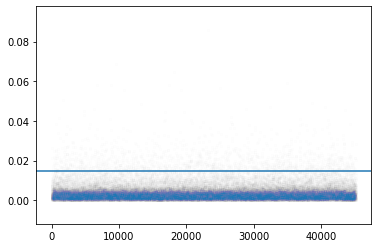

In [77]:
plt.scatter(range(len(distances)), distances, marker='.', alpha=.0051)
plt.axhline(0.07381197609536122/5)

In [78]:
df_collisions["traffic_index"] = aadt_index_nums

In [79]:
traffic_collision_series = df_collisions.groupby('traffic_index').count().CRN

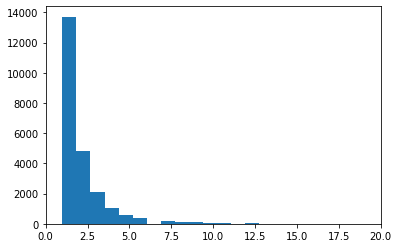

In [82]:
plt.hist(traffic_collision_series, bins=500)
plt.xlim(0, 20)
None

In [83]:
collision_per_traffic = df_traffic_shortened.copy().iloc[traffic_collision_series.index[:-1],:]
collision_per_traffic.loc[:,'CUR_AADT'] = collision_per_traffic.CUR_AADT.astype(int).values

In [84]:
collision_per_traffic.head()

,CUR_AADT,geometry
3,37768,LINESTRING (-79.9197201057041 40.5979352880057...
22,7145,LINESTRING (-79.9547751055742 40.4444171779927...
28,4494,LINESTRING (-79.89587762102187 40.445347103532...
30,1376,LINESTRING (-79.90204636284997 40.463871444125...
32,13954,LINESTRING (-80.03588169337985 40.544586323724...


In [108]:
collision_per_traffic['collision_per_aadt'] = traffic_collision_series.iloc[:-1] / collision_per_traffic.CUR_AADT
collision_per_traffic = collision_per_traffic.replace([np.inf, -np.inf], np.nan)

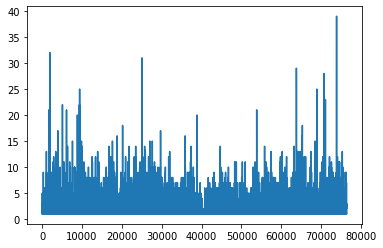

In [86]:
plt.plot(traffic_collision_series.iloc[:-1])

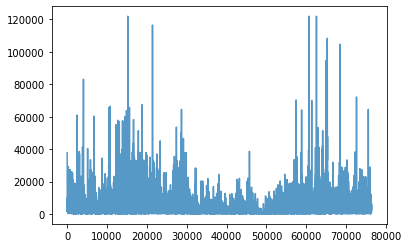

In [87]:
plt.plot(collision_per_traffic.CUR_AADT, alpha=.75)

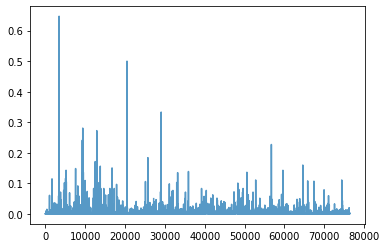

In [88]:
plt.plot(collision_per_traffic.collision_per_aadt, alpha=.75)

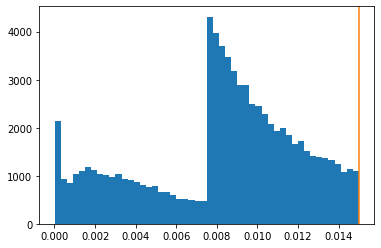

In [90]:
lengths = np.array([line.length for line in df_traffic_shortened.geometry])
plt.hist(lengths, bins=50)
plt.axvline(cutoff, color='C1')
None

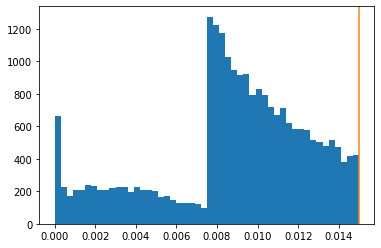

In [92]:
lengths = np.array([line.length for line in collision_per_traffic.geometry])
plt.hist(lengths, bins=50)
plt.axvline(cutoff, color='C1')
None

In [98]:
collision_per_traffic.shape

(23236, 3)

In [99]:
23236/1500

15.490666666666666

In [101]:
row.geometry.xy

(array('d', [-76.44632139441937, -76.4460709876688, -76.44570190125151, -76.44543076271756, -76.44521365568937, -76.44500755785363, -76.44479371581296, -76.44457389035254, -76.44436042673723, -76.44416452063032, -76.44398281518696, -76.4438310352097, -76.44369031043423, -76.44352020315118, -76.44333241716251, -76.44320540997357, -76.44305257909548, -76.44288548403699, -76.44271362583581, -76.44242276382853, -76.44210888492483, -76.44186693810563, -76.44164988721744, -76.4414291008516, -76.44115958316436, -76.44095595330718]),
 array('d', [40.28078725290671, 40.28063420648656, 40.28040144459478, 40.280243827902524, 40.280056092985674, 40.279898514904666, 40.279728624380404, 40.27953788392179, 40.27934843729722, 40.279159188405444, 40.27897865676138, 40.27881924465367, 40.27866606950815, 40.27846366354273, 40.27823221473737, 40.27806525029769, 40.277851023616606, 40.277601987128016, 40.277324989315886, 40.276844938539206, 40.27631695041339, 40.27591641436571, 40.27555444590153, 40.275190

In [115]:
collision_per_traffic.head()

,CUR_AADT,geometry,collision_per_aadt
3,37768,LINESTRING (-79.9197201057041 40.5979352880057...,0.000026
22,7145,LINESTRING (-79.9547751055742 40.4444171779927...,0.000140
28,4494,LINESTRING (-79.89587762102187 40.445347103532...,0.000223
30,1376,LINESTRING (-79.90204636284997 40.463871444125...,0.000727
32,13954,LINESTRING (-80.03588169337985 40.544586323724...,0.000143


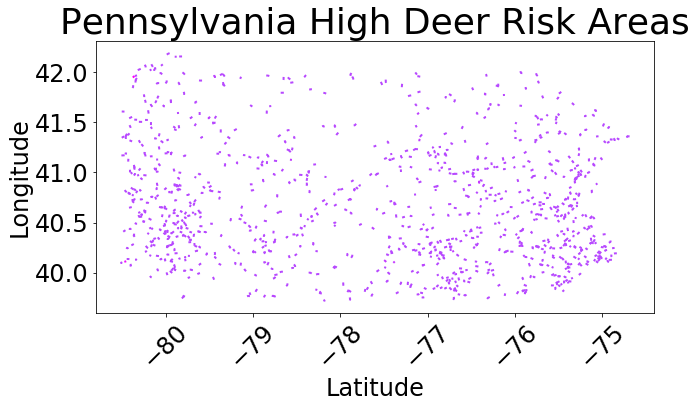

In [146]:
test = collision_per_traffic.dropna(axis='rows', subset=['geometry']).sample(1000, random_state=0)
colors = plt.get_cmap('cool') # , lut=test.collision_per_aadt.max())
plt.figure(figsize=(10, 5))
_normal = np.exp(test.collision_per_aadt).max()

for index, row in test.iloc[:,:].iterrows(): 
    #poly = row.geometry.buffer(.0075, cap_style=3)
    #test_shape = poly.simplify(0.0001, preserve_topology=False)
    #x, y = poly.exterior.xy
    x, y = row.geometry.xy
    plt.plot(x, y, 
             color=colors(np.exp(row.collision_per_aadt)/_normal),
             lw=2, alpha=1)

plt.xlabel('Latitude', fontsize=24)
plt.ylabel('Longitude', fontsize=24)
plt.title('Pennsylvania High Deer Risk Areas', fontsize=36)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)
#plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_per_avg_daily_traffic_190919.svg')
None

In [123]:
geodf = geopandas.GeoDataFrame(collision_per_traffic.dropna(axis='rows', subset=['geometry']), geometry='geometry')
#geodf.to_file('pa_collsion_per_traffic_191002.shp', driver='ESRI Shapefile')

In [122]:
geodf.shape

(23236, 3)

In [135]:
mask_collisions = df_traffic_shortened.index.isin(traffic_collision_series.index[:-1])
sample = df_traffic_shortened[~mask_collisions].sample(10000, random_state=0)
no_crash_geodf = geopandas.GeoDataFrame(sample, geometry='geometry')
no_crash_geodf['collision'] = 0
no_crash_geodf.dropna(inplace=True)
#no_crash_geodf.to_file('pa_no_crash_geometries_191002.shp', driver='ESRI Shapefile')

In [137]:
import overpass
import time

In [138]:
def make_feature_dict(df, features, prefix=None):
    """
    
    Parameters
    ----------
    df : geopandas.geodataframe.GeoDataFrame
        Dataframe containing features pulled from overpass API
        
    features : list
        List of column names associated with high-level feature names
        employed by overpass/OSM. Reference here:
        https://wiki.openstreetmap.org/wiki/Map_Features
        
    prefix : str
        Additional identifier placed before feature name.
        
    Returns
    -------
    dict
        Nested dictionary of features with value counts as eventual values.
        
    """
    
    if prefix!=None:
        pass
    else:
        prefix=''
        
    feature_dict = {}
    for feature in features:
        if feature in df.columns:
            series = df[feature].value_counts()
            feature_dict[prefix+feature] = { k:v for (k,v) in zip(series.index, series.values)}
        else:
            feature_dict[prefix+feature] = None
    return feature_dict

In [140]:
cols = [
    'aeroway',
    'amenity',
    'barrier',
    'boundary',
    'building',
    'healthcare',
    'highway',
    'landuse',
    'leisure',
    'man_made',
    'natural',
    'parking',
    'power',
    'railway',
    'route',
    'service',
    'surface',
    'tourism',
    'waterway'
]

In [148]:
endpoint = 'https://overpass.kumi.systems/api/interpreter'
endpoint = 'https://z.overpass-api.de/api/interpreter'
endpoint = 'https://lz4.overpass-api.de/api/interpreter'
api_pass = overpass.API(timeout=7200, endpoint=endpoint)
road_responses, area_responses = list(), list()
i = 5226

for index, row in no_crash_geodf.iloc[i:,:].iterrows(): 
    print(i, end=', ')
    poly = row.geometry.buffer(.00375, cap_style=3)
    test_shape = poly.simplify(0.001, preserve_topology=False)
    
    # Building overpass queries
    road_query = 'nwr(around:1, {c[1]}, {c[0]});(._;>;);out;'.format(
        c=row.geometry.interpolate(0.5, normalized = True).coords[:][0])
    area_query = 'nwr(poly:"{}");out;'.format(
        ' '.join('{c[1]} {c[0]}'.format(c=c) for c in test_shape.exterior.coords[:]))
    
    # Getting overpass road responses
    road_response = api_pass.get(road_query)
    #road_responses.append(road_response)
    road_geodf = geopandas.GeoDataFrame.from_features(road_response)
    culled_road = road_geodf.dropna(axis='index', how='all', subset=road_geodf.columns[1:])
    # Overwriting feature_dict each time
    feature_dict = make_feature_dict(culled_road, ['highway', 'surface'], prefix='road_')
    time.sleep(.5)
    
    # Getting overpass area responses
    response = api_pass.get(area_query)
    #area_responses.append(response)
    geodf = geopandas.GeoDataFrame.from_features(response)
    culled_geodf = geodf.dropna(axis='index', how='all', subset=geodf.columns[1:])
    feature_dict.update(make_feature_dict(culled_geodf, cols, prefix='area_'))
    pd.io.json.json_normalize(feature_dict).to_csv('overpass_one_mile_191002/no_crashes/{}.csv'.format(str(i).rjust(4,'0')))
    time.sleep(.5)
    i += 1

5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 

KeyboardInterrupt: 